IMPORT MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions
import scipy.integrate
import scipy.optimize
import scipy.stats

CONSTANTS

In [2]:
H_0 = 75 * 10**3 / (3.086*10**22) # s^-1
m_0 = -20.45
c = 3*10**8 # m/s

Investigate relationship between luminosity distance and redshift

_NOTE: We expect a  roughly linear relationship between distance and redshift, known as Hubble’s Law. However, if we extend the measurement to more distant objects, the relation becomes curved, and strongly dependent on the matter content of the Universe._

Text(0, 0.5, 'Redshift $z$')

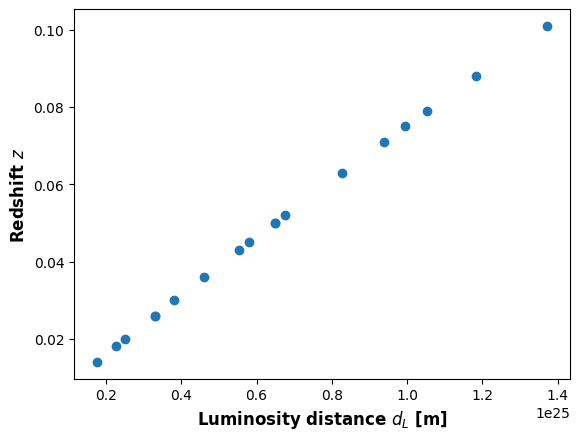

In [3]:
#reads data
name, redshift, eff_peak_mag, mag_err = functions.read_data('sn_data.txt')

#z < 0.1 data
low_redshift_indices = np.where(redshift<0.102)[0]
comoving_distance = functions.get_comoving_distance_low_z(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], H_0)
peak_flux, peak_flux_err = functions.get_flux(eff_peak_mag, mag_err, m_0)
d_L = functions.get_luminosity_distance(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], comoving_distance)
plt.scatter(d_L, redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1])
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Redshift $z$', weight = 'bold', fontsize = 12)

Plotting effective magnitude against luminosity distance and fitting a curve to obtain the peak luminosity.

Text(0, 0.5, 'Effective magnitude $m_{eff}$')

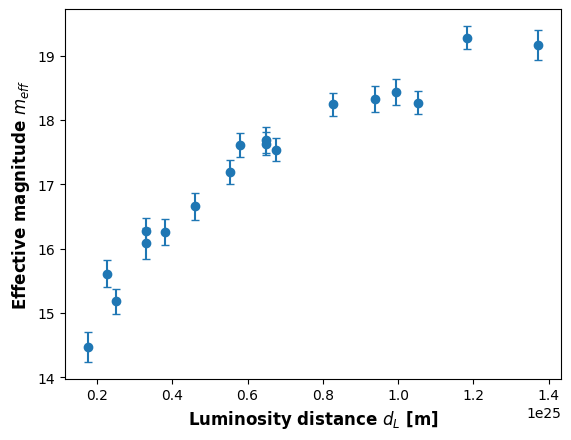

In [4]:
plt.errorbar(d_L, eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1], yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1], 
             ls='none', marker = 'o', capsize = 3)
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Effective magnitude $m_{eff}$', weight = 'bold', fontsize = 12)

DoF = 17
Optimised parameters =  [3.26596058e+39] 

Covariance matrix = 
 [[1.95258522e+76]]


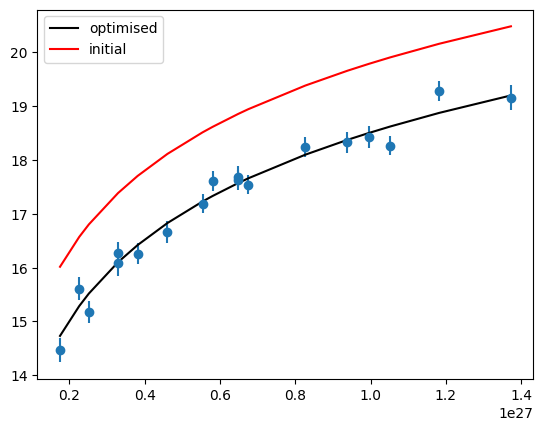

chi^2_min = 21.455532501736517
reduced chi^2 = 1.2620901471609716
$P(chi^2_min, DoF)$ = 0.2065742384451868


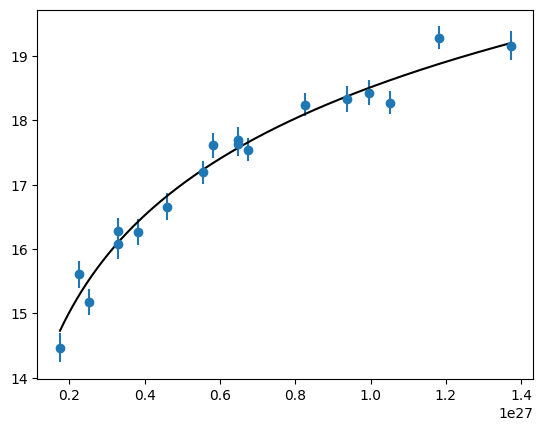

optimised parameter[0] = 3.265960579801944e+39 +/- 1.397349355509028e+38


In [5]:
#chi squared fitting

xval = d_L*100 # cm
yval = eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1]

def model_funct(x, *vals):
    return -2.5*np.log10(vals[0]/(4*np.pi*x**2)) - 20.45

initial = np.array([1.0*10**39]) # Initial guess for fit parameters

parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial) #optimised parameters given in erg/s/Ang
L_peak = parameters[0][0]*10**-7
L_peak_err = parameters[1][0]*10**-7

Calculate Ω_Λ,0

In [6]:
#omega_lambda = 0.73


#print(mag_model(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1], L_peak, H_0, m_0, omega_lambda))
#print(eff_peak_mag[high_redshift_indices[0]:high_redshift_indices[-1]+1])
#print(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1])
#print((c*integrate_array(comoving_distance_integrand, np.zeros(len(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1])), redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1], args=(H_0, omega_lambda))/(3.086*10**22)))

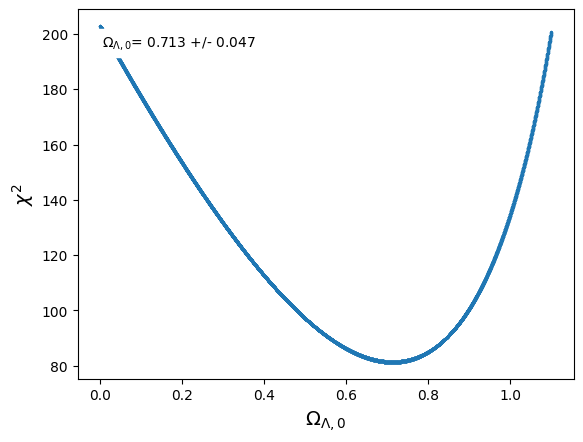

In [7]:
#Now for an array of values of omega_lambda
high_redshift_indices = np.where(redshift > 0.102)[0]


def find_omega_lambda_and_error():
    no_of_values = 10000
    omega_lambdas = np.linspace(0, 1.1, no_of_values)
    actual = eff_peak_mag[high_redshift_indices[0]:high_redshift_indices[-1]+1]
    error = mag_err[high_redshift_indices[0]:high_redshift_indices[-1]+1]
    chi_squared = []
    for omega_lambda in omega_lambdas:
        predicted = functions.mag_model(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1], L_peak, H_0, m_0, omega_lambda)
        chi_squared.append(np.sum((actual-predicted)**2/error**2))

    min_index = np.argmin(chi_squared)
    omega_lambda = np.round(omega_lambdas[min_index], 3)
    min_chisq = chi_squared[min_index]
    counter = 0
    errors = []
    try:
        while True:
            if chi_squared[min_index+counter]-min_chisq > 1:
                errors.append(omega_lambdas[min_index+counter]-omega_lambda)
                break
            else:
                counter += 1
    except:
        print('Error calculation exceeds maximum trial value!')

    counter = 0
    try:
        while True:
            if chi_squared[min_index-counter]-min_chisq > 1:
                errors.append(omega_lambdas[min_index-counter]-omega_lambda)
                break
            else:
                counter += 1
    except:
        print('Error calculation exceeds minimum trial value!')

    omega_lambda_err = np.round(np.max(errors), 3)

    plt.scatter(omega_lambdas, chi_squared, marker = 'x', s = 2)
    plt.xlabel('$Ω_{Λ,0}$', fontsize = 14)
    plt.ylabel('$χ^2$', fontsize = 14)
    plt.annotate('$Ω_{Λ,0}$' + f'= {omega_lambda} +/- {omega_lambda_err}', xycoords = 'axes fraction', xy = (0.05, 0.9), backgroundcolor = 'white')
    plt.show()

    return omega_lambda, omega_lambda_err

values = find_omega_lambda_and_error()
omega_lambda = values[0]; omega_lambda_err = values[1]


In [8]:
#print(comoving_distance)
#print(c*integrate_array(comoving_distance_integrand, np.zeros(len(redshift)), redshift, args=(H_0, omega_lambda)))
#print(c*integrate_array(comoving_distance_integrand, np.zeros(len(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1])), redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], args=(H_0, omega_lambda)))